In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import mlflow
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature

from sd_vae.ae import VAE
from trainers import EarlyStopping
from trainers.first_stage_trainer import CLEAR_VAEFirstStageTrainer

from modules.loss import SupCon, SNN

import data_utils.styled_mnist.corruptions as corruptions
from data_utils.styled_mnist.data_utils import StyledMNISTGenerator, StyledMNIST

%load_ext autoreload
%autoreload 2

In [2]:
mnist = MNIST("./data", train=True, download=False)

In [3]:
generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)
dataset = StyledMNIST(
    generator, 
    transforms.Compose([
        transforms.ToTensor(), 
        lambda img: img / 255.0,
    ])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])

Generating dataset: 100%|██████████| 60000/60000 [00:15<00:00, 3948.54item/s]


In [4]:
train_loader = DataLoader(train, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid, batch_size=128, shuffle=False)
test_loader = DataLoader(test, batch_size=128, shuffle=False)

In [11]:
params = {
    "lr": 5e-4,
    "optimizer": "Adam",
    "batch_size": 256,
    "channel_split": [1, 1],
    "beta": 1 / 8,
    "gamma": 100,
    "z_channels": 2,
    "contrastive_module": "SNN",
    "pool": "flatten",
    "use_proj": False,
    "temperature": [0.2, 0.3],
}

input_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
output_schema = Schema([TensorSpec(np.dtype(np.float32), [-1, 1, 32, 32])])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

vae = VAE(
    channels=32,
    channel_multipliers=[1, 2, 4],
    n_resnet_blocks=1,
    x_channels=1,
    z_channels=params["z_channels"],
    norm_channels=32,
    n_heads=4,
).cuda()

trainer = CLEAR_VAEFirstStageTrainer(
    contrastive_criterions={
        "content": eval(params["contrastive_module"])(
            temperature=params["temperature"][0],
            pool=params["pool"],
            use_proj=params["use_proj"],
        ).cuda(),
        "style": eval(params["contrastive_module"])(
            temperature=params["temperature"][1],
            pool=params["pool"],
            use_proj=params["use_proj"],
        ).cuda(),
    },
    model=vae,
    early_stopping=EarlyStopping(patience=8),
    verbose_period=2,
    device="cuda",
    model_signature=signature,
    args={
        "beta": params["beta"],
        "gamma": params["gamma"],
        "vae_lr": params["lr"],
        "channel_split": params["channel_split"],
    },
)

In [12]:
mlflow.set_tracking_uri("./mlruns")
mlflow.set_experiment("test")
with mlflow.start_run():
    mlflow.log_params(params)
    trainer.fit(epochs=25, train_loader=train_loader, valid_loader=valid_loader)

100%|██████████| 79/79 [00:01<00:00, 66.85batch/s]


epoch 0/val_rec: 34.2323
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 68.71batch/s]


epoch 2/val_rec: 25.7716
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 68.44batch/s]


epoch 4/val_rec: 18.3518
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 67.99batch/s]


epoch 6/val_rec: 20.5007


100%|██████████| 79/79 [00:01<00:00, 67.82batch/s]


epoch 8/val_rec: 15.5057
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 68.13batch/s]


epoch 10/val_rec: 14.5290
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 68.04batch/s]


epoch 12/val_rec: 12.8523
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 68.14batch/s]


epoch 14/val_rec: 12.4480


100%|██████████| 79/79 [00:01<00:00, 65.67batch/s]


epoch 16/val_rec: 11.1010
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 66.64batch/s]


epoch 18/val_rec: 11.1722


100%|██████████| 79/79 [00:01<00:00, 66.68batch/s]


epoch 20/val_rec: 10.2925
[INFO]: track model state


100%|██████████| 79/79 [00:01<00:00, 64.99batch/s]


epoch 22/val_rec: 10.9020


100%|██████████| 79/79 [00:01<00:00, 66.06batch/s]


epoch 24/val_rec: 11.1312
[INFO]: log best model


In [14]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

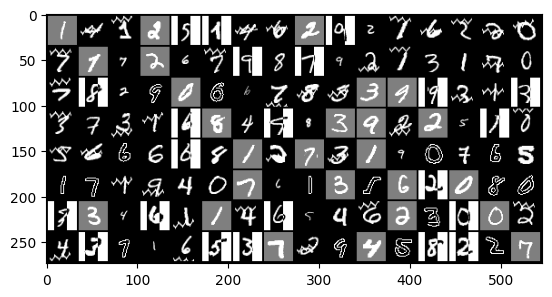

In [15]:
batch = next(iter(test_loader))
x, y = batch['image'].to("cuda"), batch['label'].to("cuda")
plt.imshow(make_grid(x, nrow=16).cpu().permute(1,2,0))

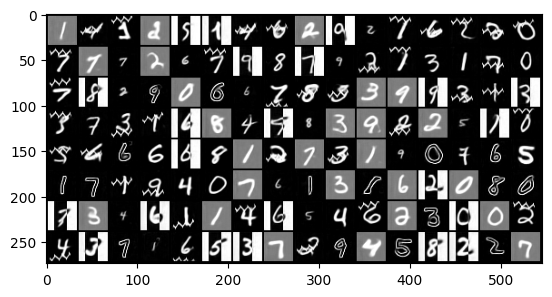

In [16]:
x = next(iter(test_loader))['image'].to("cuda")
best_model = mlflow.pytorch.load_model('runs:/c8998133fa0e452cac8f9f6205207f4e/best_model')
with torch.no_grad():
    best_model.eval()
    xhat, posterior = best_model(x)
    plt.imshow(make_grid(xhat, nrow=16).cpu().permute(1,2,0))

torch.Size([128, 2, 8, 8])


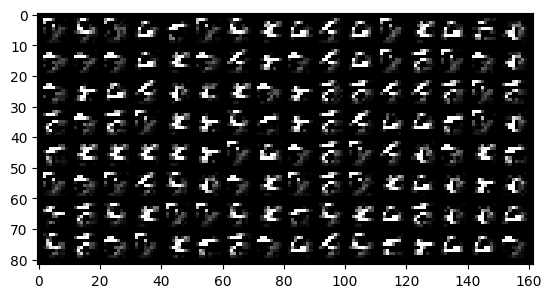

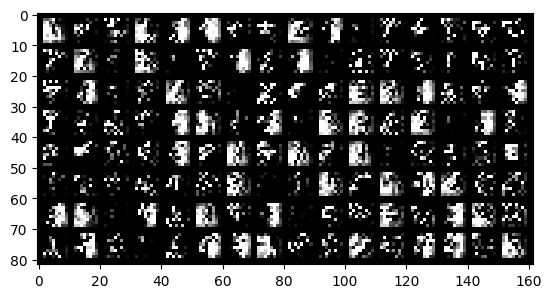

In [17]:
mu = posterior.mu
print(mu.shape)
for i in range(mu.shape[1]):
    plt.imshow(make_grid(mu[:,i][:,None,:,:], nrow=16).cpu().permute(1,2,0))
    plt.show()

In [18]:
from tqdm import tqdm

In [19]:
z_cs = []
z_ss = []
labels = []
styles = []

with torch.no_grad():
    best_model.eval()
    for batch in tqdm(test_loader):
        x = batch['image'].cuda()
        _, posterior = best_model(x)
        z_c, z_s = posterior.sample().split_with_sizes(params["channel_split"], dim=1)
        z_cs.append(z_c.cpu())
        z_ss.append(z_s.cpu())
        labels.append(batch['label'])
        styles.append(batch['style'])

z_cs = torch.cat(z_cs, dim=0)
z_ss = torch.cat(z_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


100%|██████████| 79/79 [00:01<00:00, 59.74it/s]


In [20]:
from sklearn.manifold import TSNE

In [21]:
tsne = TSNE(n_components=2, init='pca')
z_2d = tsne.fit_transform(z_cs.view(z_cs.shape[0], -1).numpy())

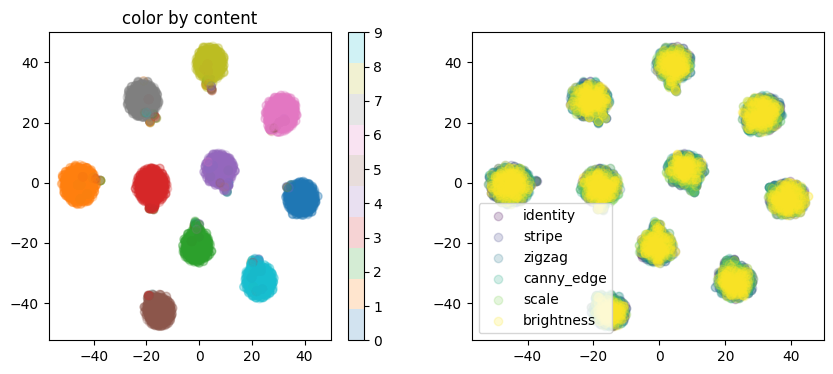

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs0 = axs[0].scatter(z_2d[:, 0], z_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.2)
cbar = fig.colorbar(axs0, ax=axs[0])
axs[0].set_title('color by content')

style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale','brightness']
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    axs[1].scatter(z_2d[i,0], z_2d[i,1], alpha=0.2, c=colors[g], label=style_labels[g])
axs[1].legend()
plt.show()

In [23]:
tsne = TSNE(n_components=2, init='pca')
z_2d = tsne.fit_transform(z_ss.view(z_ss.shape[0], -1).numpy())

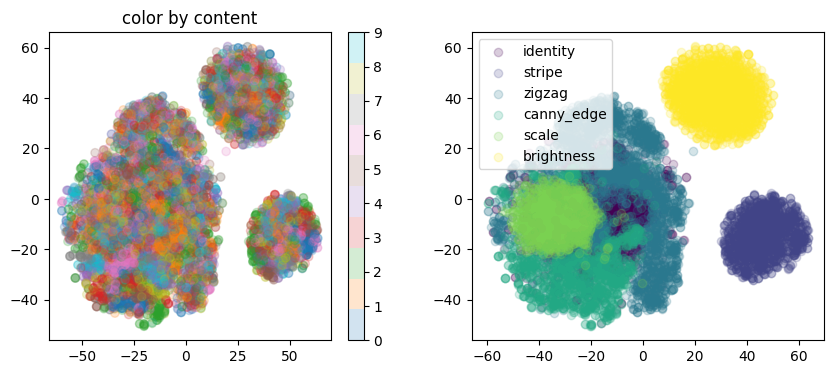

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs0 = axs[0].scatter(z_2d[:, 0], z_2d[:, 1], c=labels.numpy(), cmap='tab10', alpha=0.2)
cbar = fig.colorbar(axs0, ax=axs[0])
axs[0].set_title('color by content')

style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale','brightness']
cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    axs[1].scatter(z_2d[i,0], z_2d[i,1], alpha=0.2, c=colors[g], label=style_labels[g])
axs[1].legend()
plt.show()

In [25]:
from exp_utils.visual import feature_swapping_plot

In [26]:
z_c, z_s = mu.split_with_sizes(params['channel_split'], dim=1)
x = next(iter(test_loader))['image'].to("cuda")

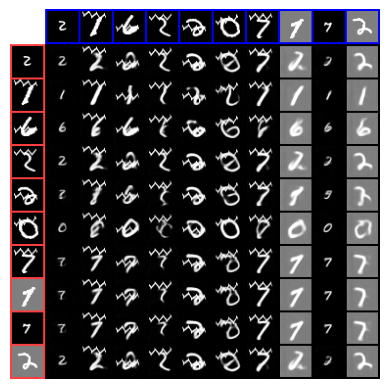

In [27]:
feature_swapping_plot(
     z_c[10:20],
     z_s[10:20],
     x[10:20],
     best_model,
)

In [ ]:
torch.cat([torch.rand(3, 580, 206), torch.rand(3, 36, 206)], dim=1)